In [2]:
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
df = pd.read_csv('../data/measures-chuc-4xA100-burn180-full.csv')
df.reset_index(inplace=True)

drop_everything_before_measure = 'MIG_1g.5gb|1g.5gb|idle'

timestamp_decrease = df.timestamp.diff() < 0
restart = timestamp_decrease[timestamp_decrease].index.values
range_start = df.loc[df['measure'] == drop_everything_before_measure].iloc[0].values[0].astype(int)
frames = []
for range_end in restart:
    if range_start>0:
        focus = df[range_start:range_end].pivot(index=['timestamp','domain'], columns='metric', values='measure')
        focus.reset_index(inplace=True)
        pivot = focus.pivot(index='timestamp', columns='domain', values='SMI_power.draw')
        frames.append(pd.concat([pivot, focus], axis=1))
    range_start = range_end
focus = df[range_start:].pivot(index=['timestamp','domain'], columns='metric', values='measure')
focus.reset_index(inplace=True)
pivot = focus.pivot(index='timestamp', columns='domain', values='SMI_power.draw')
frames.append(pd.concat([pivot, focus], axis=1))

dataset = pd.concat(frames)
dataset.set_index(['timestamp','domain', 'CONST_context'], inplace=True)
dataset_keys = list(dataset.keys())
if 'SMI_PSTATE' in dataset_keys: dataset_keys.remove('SMI_PSTATE')
if 'SMI_pstate' in dataset_keys: dataset_keys.remove('SMI_pstate')
dataset = dataset.astype({key:'float' for key in dataset_keys})
dataset.reset_index(inplace=True)

/tmp/ipykernel_12414/1451950317.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset.reset_index(inplace=True)
/tmp/ipykernel_12414/1451950317.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset.reset_index(inplace=True)
/tmp/ipykernel_12414/1451950317.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

# Graph time

In [92]:
ipmi_keys = [key for key in dataset_keys if 'IPMI' in key]
domain = ['GPU0', 'GPU1', 'GPU2', 'GPU3']
domain_ipmi_keys = domain + ipmi_keys
timestamp_ipmi_keys = ['timestamp'] + domain_ipmi_keys

corr = dataset[domain_ipmi_keys].corr(method = 'spearman')
corr_filtered = corr[:len(domain)][ipmi_keys].T.dropna()

In [93]:
len(corr_filtered)

47

<Axes: >

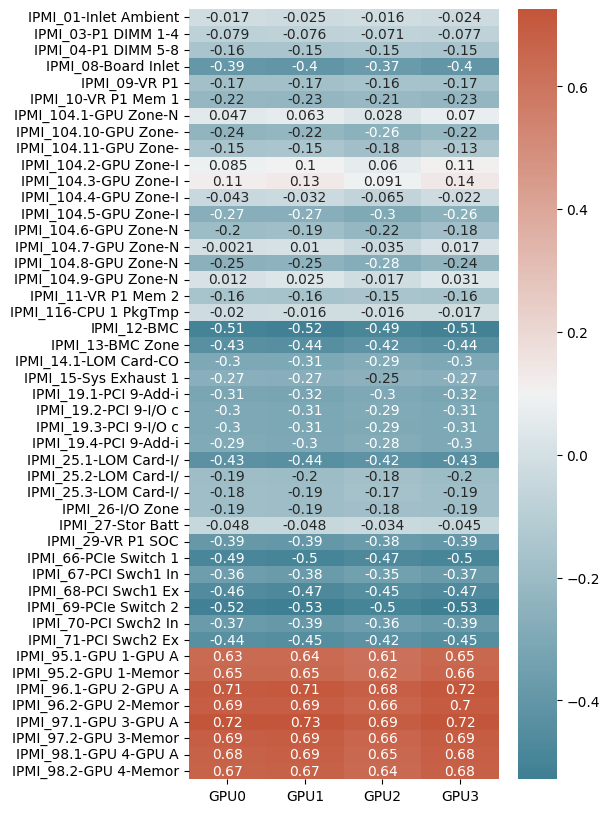

In [102]:
fig, ax = plt.subplots(figsize=(5, 10))  # Set the figure size

sns.heatmap(corr_filtered, ax=ax, annot = True, cmap=sns.diverging_palette(220, 20, as_cmap=True))